In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('data/logs.csv')
display(df.shape)
df.head()

(2065516, 16)

,id,databaseType,totalMem,timeRead,timeDelete,totalTime,timestamp,serverType,clientTotalTime,requestSize,cpuUsage,frequency,instanceType,freeMem,timeWrite,memUsage
0,--4qETfhcD,nosql,-1.0,-1.0,-1.0,-1.0,-1.0,java,-1.0,50.0,-1.0,15.0,b1,-1.0,-1.0,-1.0
1,--Lo0QBj3fC,nosql,-1.0,-1.0,-1.0,-1.0,-1.0,java,-1.0,200.0,-1.0,40.0,b1,-1.0,-1.0,-1.0
2,--P-Z58M2G,nosql,-1.0,-1.0,-1.0,-1.0,-1.0,java,-1.0,1.0,-1.0,15.0,b1,-1.0,-1.0,-1.0
3,--nUeIfVXJ,nosql,-1.0,-1.0,-1.0,-1.0,-1.0,java,-1.0,100.0,-1.0,15.0,b1,-1.0,-1.0,-1.0
4,--od3lhTv,nosql,-1.0,-1.0,-1.0,-1.0,-1.0,java,-1.0,100.0,-1.0,15.0,b1,-1.0,-1.0,-1.0


In [2]:
servers = sorted(['java', 'nodejs'])
databases = sorted(['nosql', 'sql'])
instances = sorted(['b1', 'b2', 'b4', 'b8'])

combinations = [(servers[0], databases[0]), (servers[1], databases[0]), (servers[0], databases[1]), (servers[1], databases[1])]

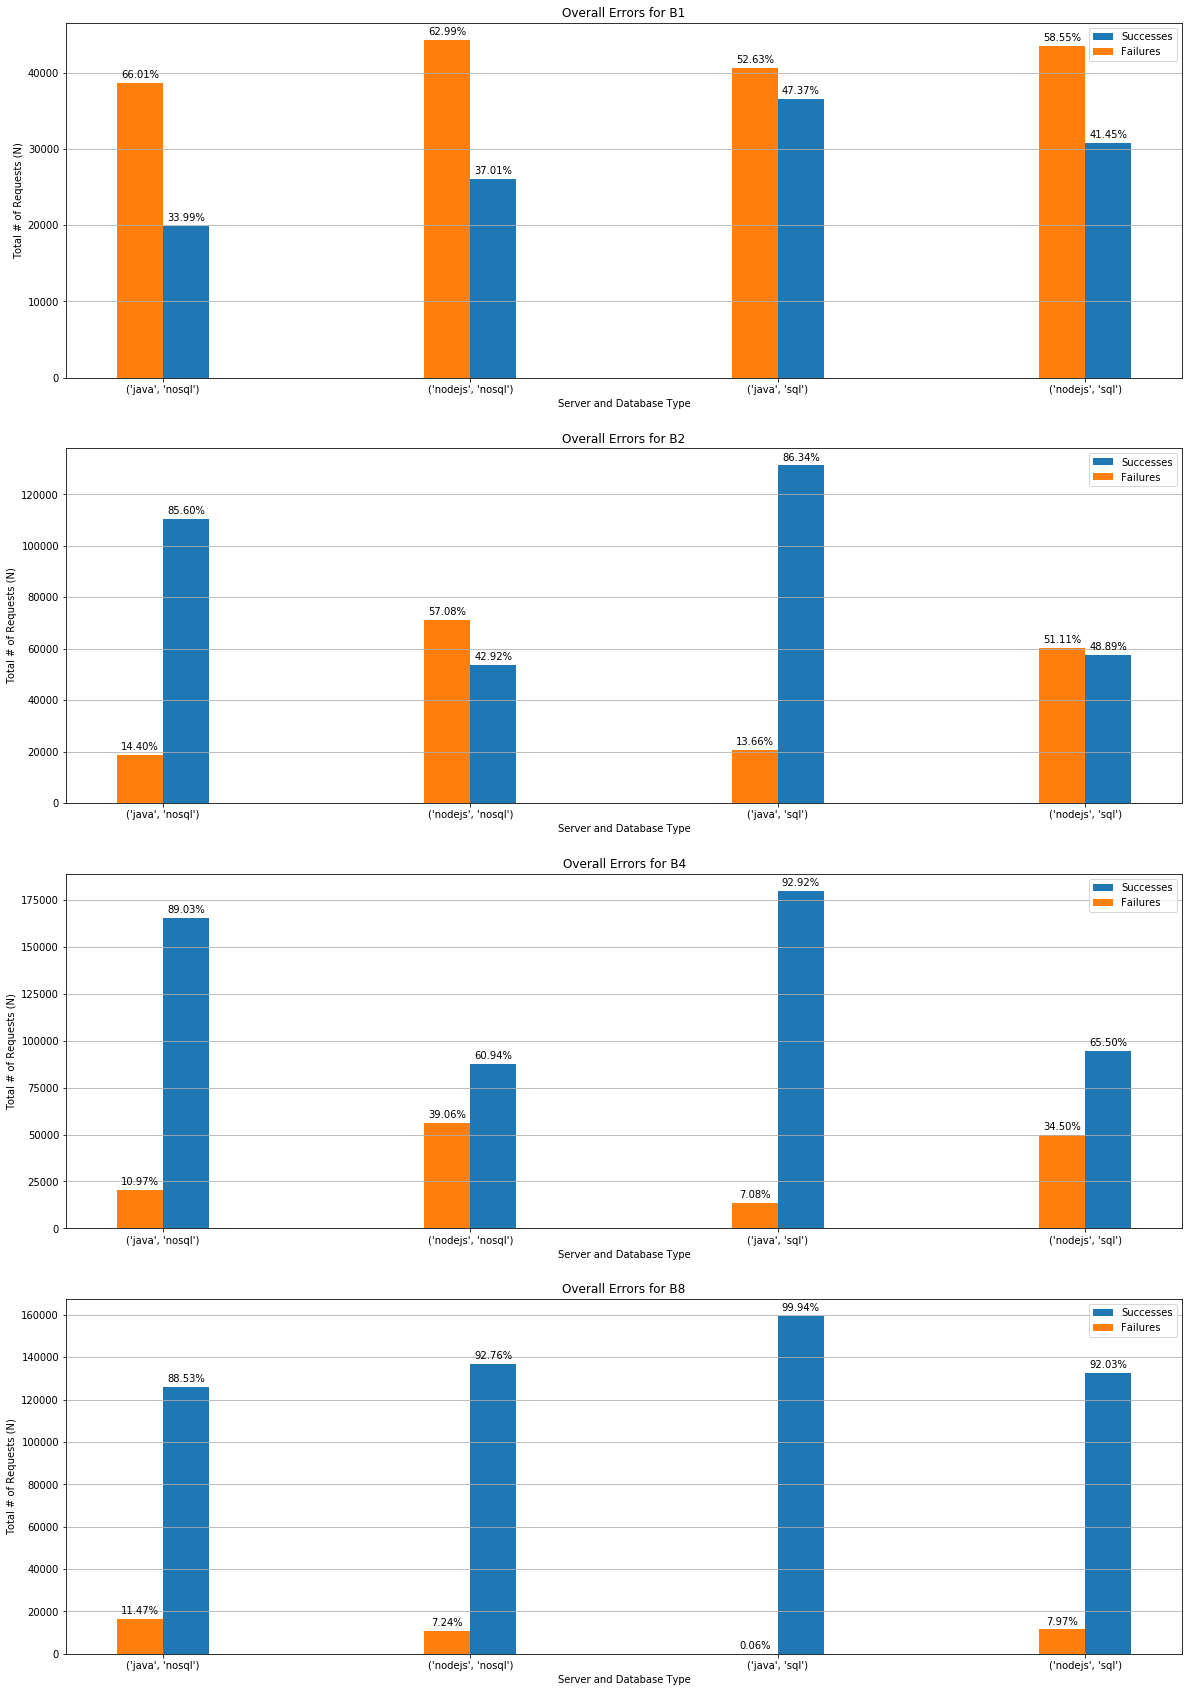

In [3]:
def autolabel1(rects, other_rects):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        other_height = other_rects[i].get_height()
        pct = (100 * height / (height + other_height))
                
        ax.annotate('{:.2f}%'.format(pct), xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')


fig, axes = plt.subplots(4)

for i, instance in enumerate(instances):
    ax = axes[i]
    
    success_arr = []
    error_arr = []
    ns = []
    
    for combination in combinations:
        server, database = combination

        partial = df.loc[(df['instanceType'] == instance) & (df['serverType'] == server) & (df['databaseType'] == database)]
        
        error = partial[(partial.clientTotalTime <= 0) | (partial.requestSize <= 0) |
                            (partial.frequency <= 0) | (partial.timeWrite <= 0) | (partial.timeRead <= 0) |
                            (partial.timeDelete <= 0) | (partial.totalTime <= 0) | (partial.timestamp <= 0) |
                           (partial.memUsage <= 0)].shape[0]
        
        total = partial.shape[0]
        success = total - error
        success_arr.append(success)
        error_arr.append(error)
        ns.append(total)

    ind = np.arange(len(combinations))  
    width = 0.15
    rects1 = ax.bar(ind + 0.5 * width, success_arr, width, label='Successes')
    rects2 = ax.bar(ind - 0.5 * width, error_arr, width, label='Failures')

    ax.set_ylim(0)
    ax.set_title('Overall Errors for {}'.format(instance.upper()))
    ax.set_xticks(ind)
    ax.set_xticklabels(combinations)
    ax.legend()
    ax.autoscale_view()
    ax.yaxis.grid(True)
    ax.set_ylabel('Total # of Requests (N)')
    ax.set_xlabel('Server and Database Type')
    autolabel1(rects1, rects2)
    autolabel1(rects2, rects1)


fig.set_size_inches(20, 30)
plt.savefig('graphs/errors/overall-errors.png', bbox_inches='tight')
plt.show()

In [4]:
combs = []

for instance in instances:
    for server in servers:
        for database in databases:
            combs.append((instance, server, database))

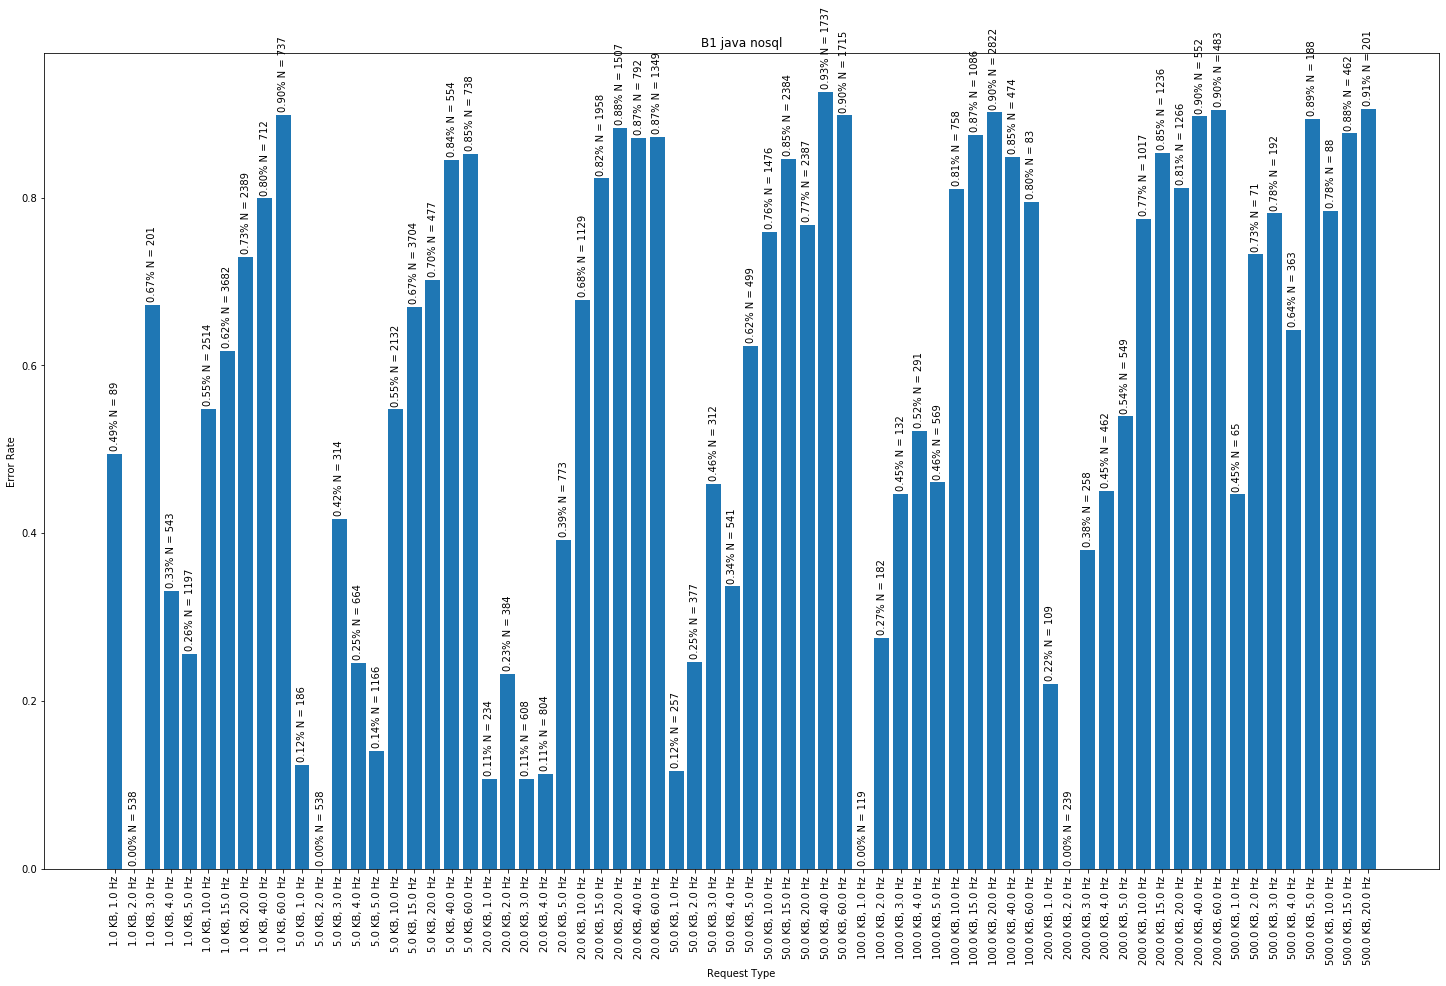

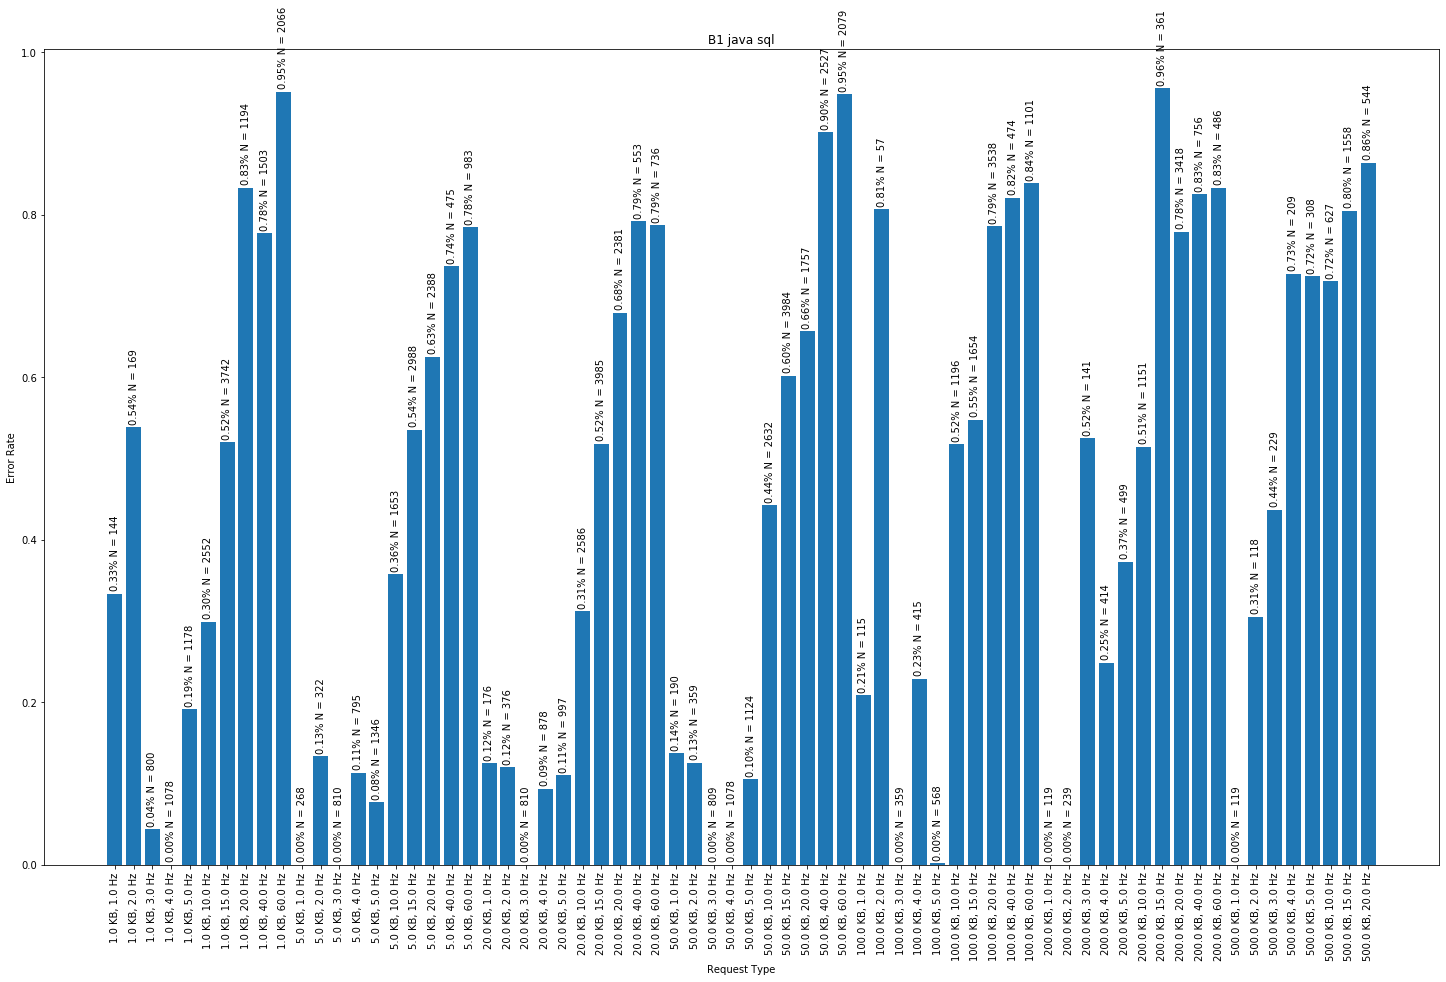

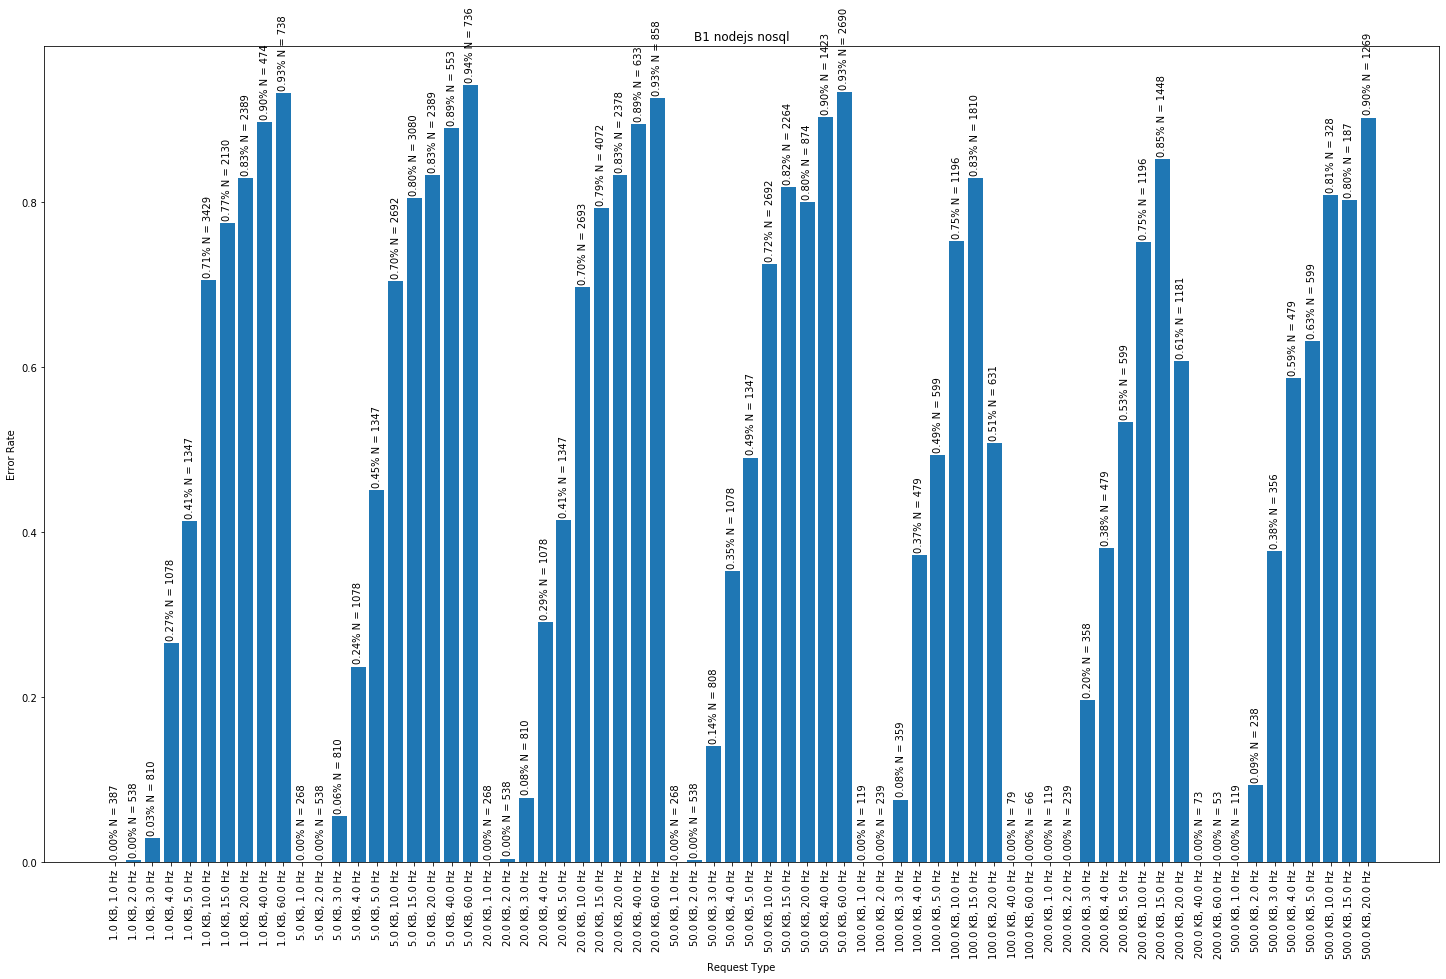

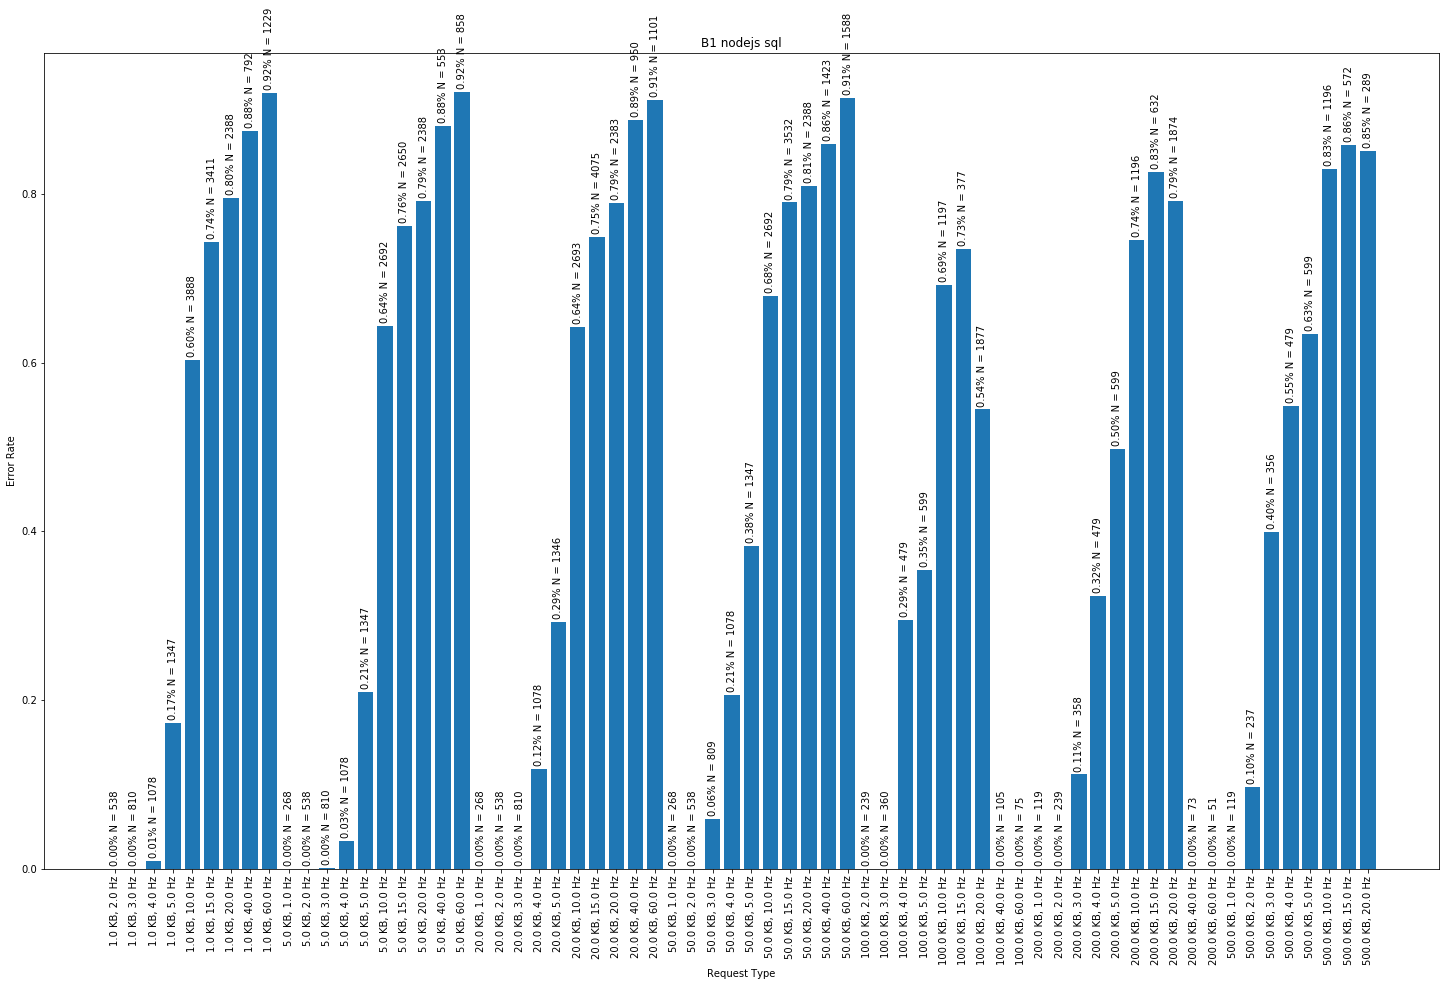

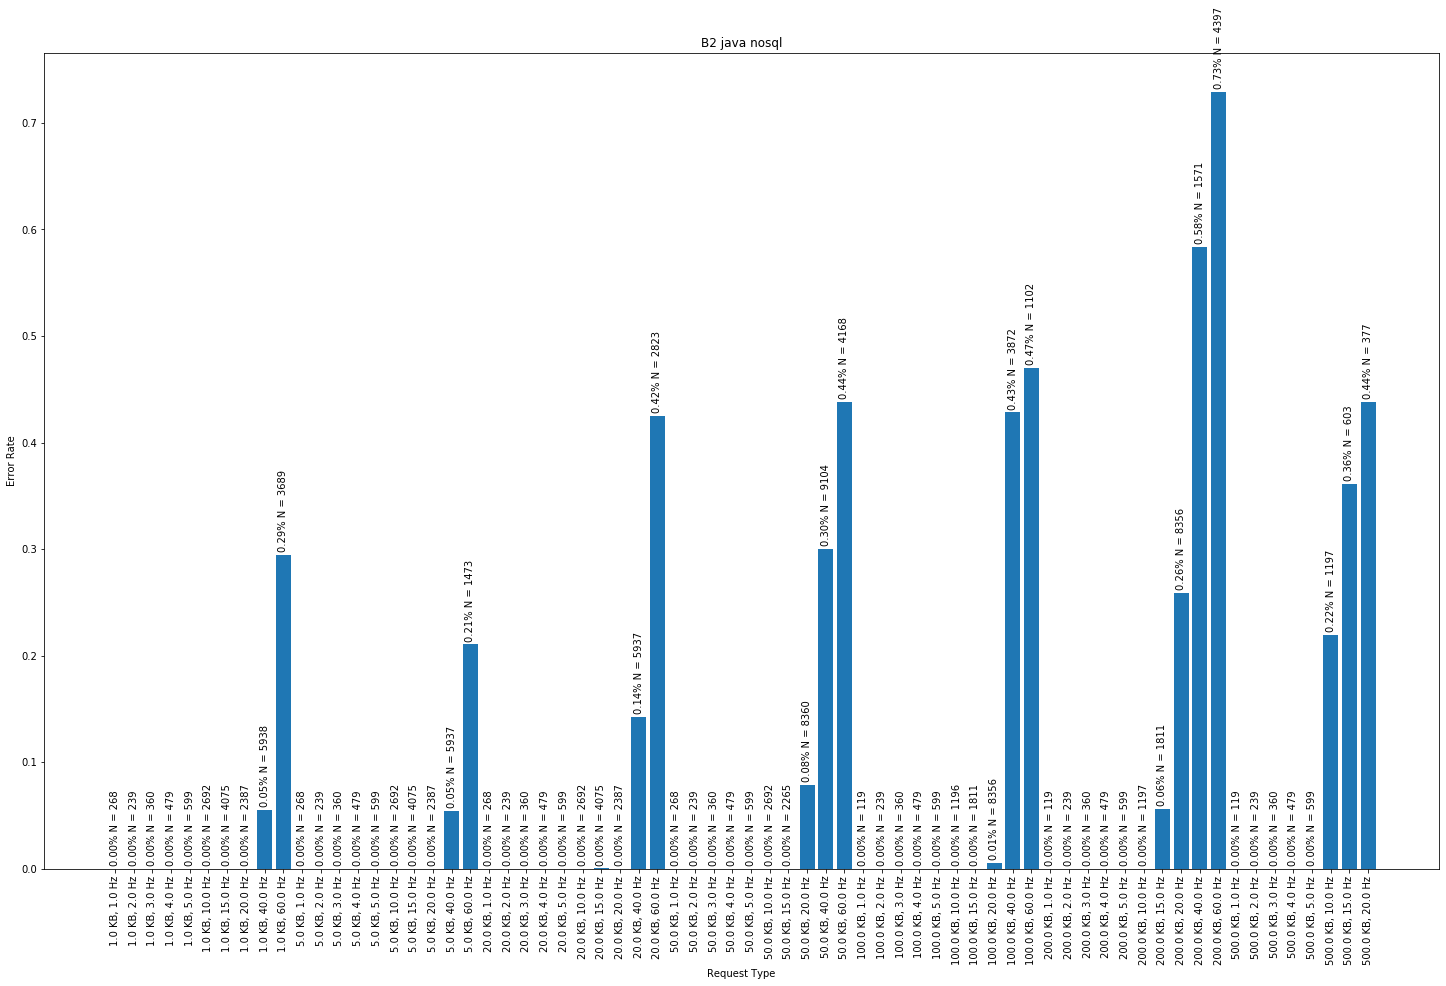

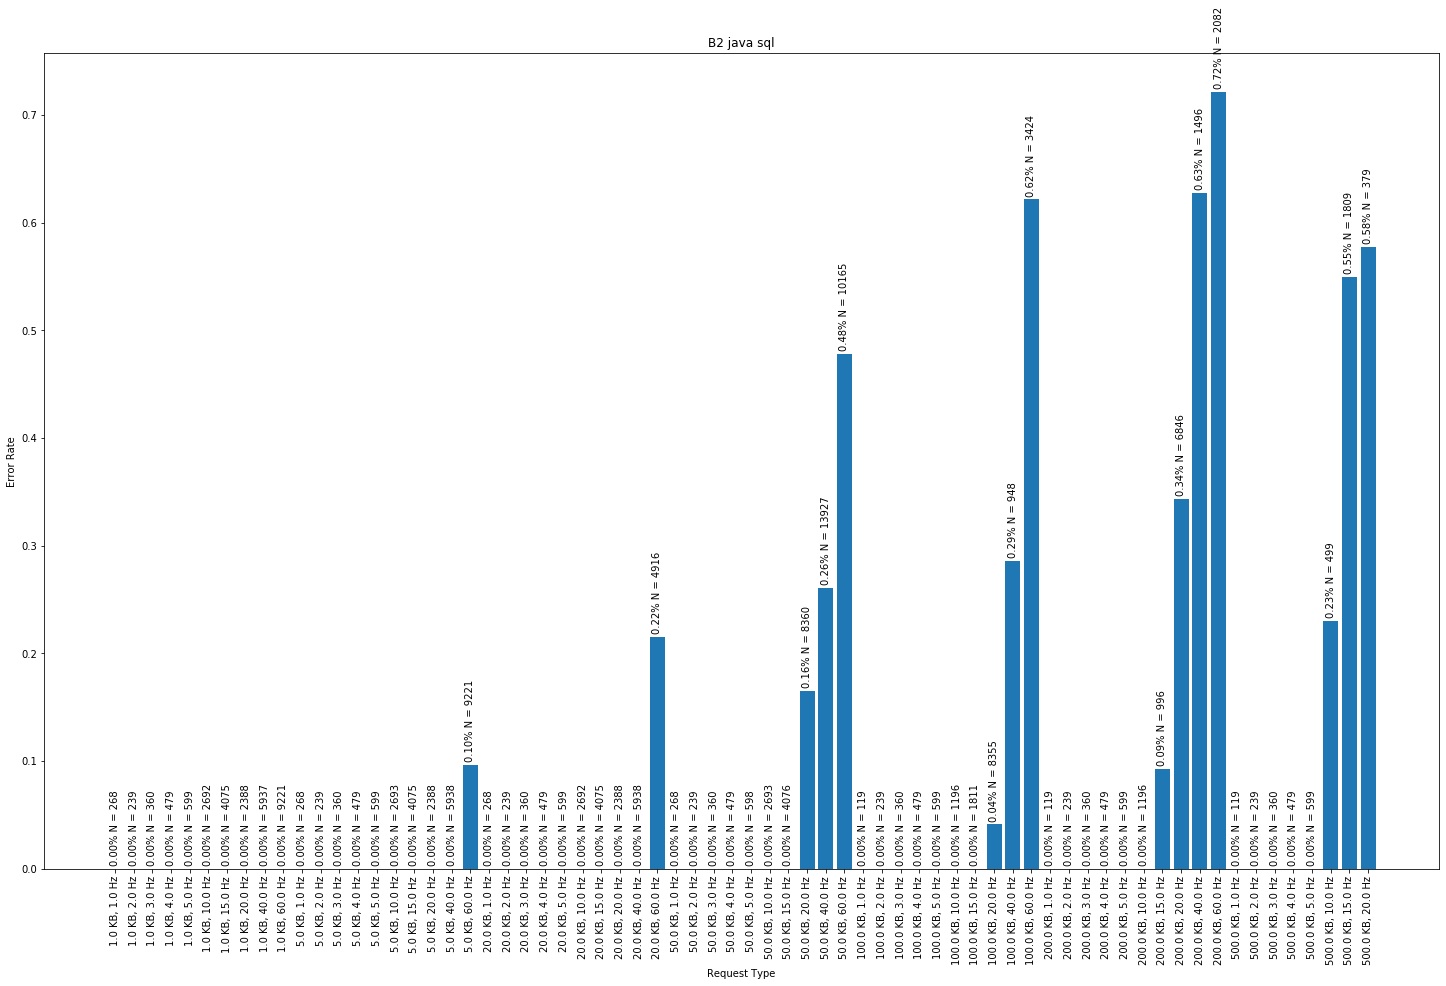

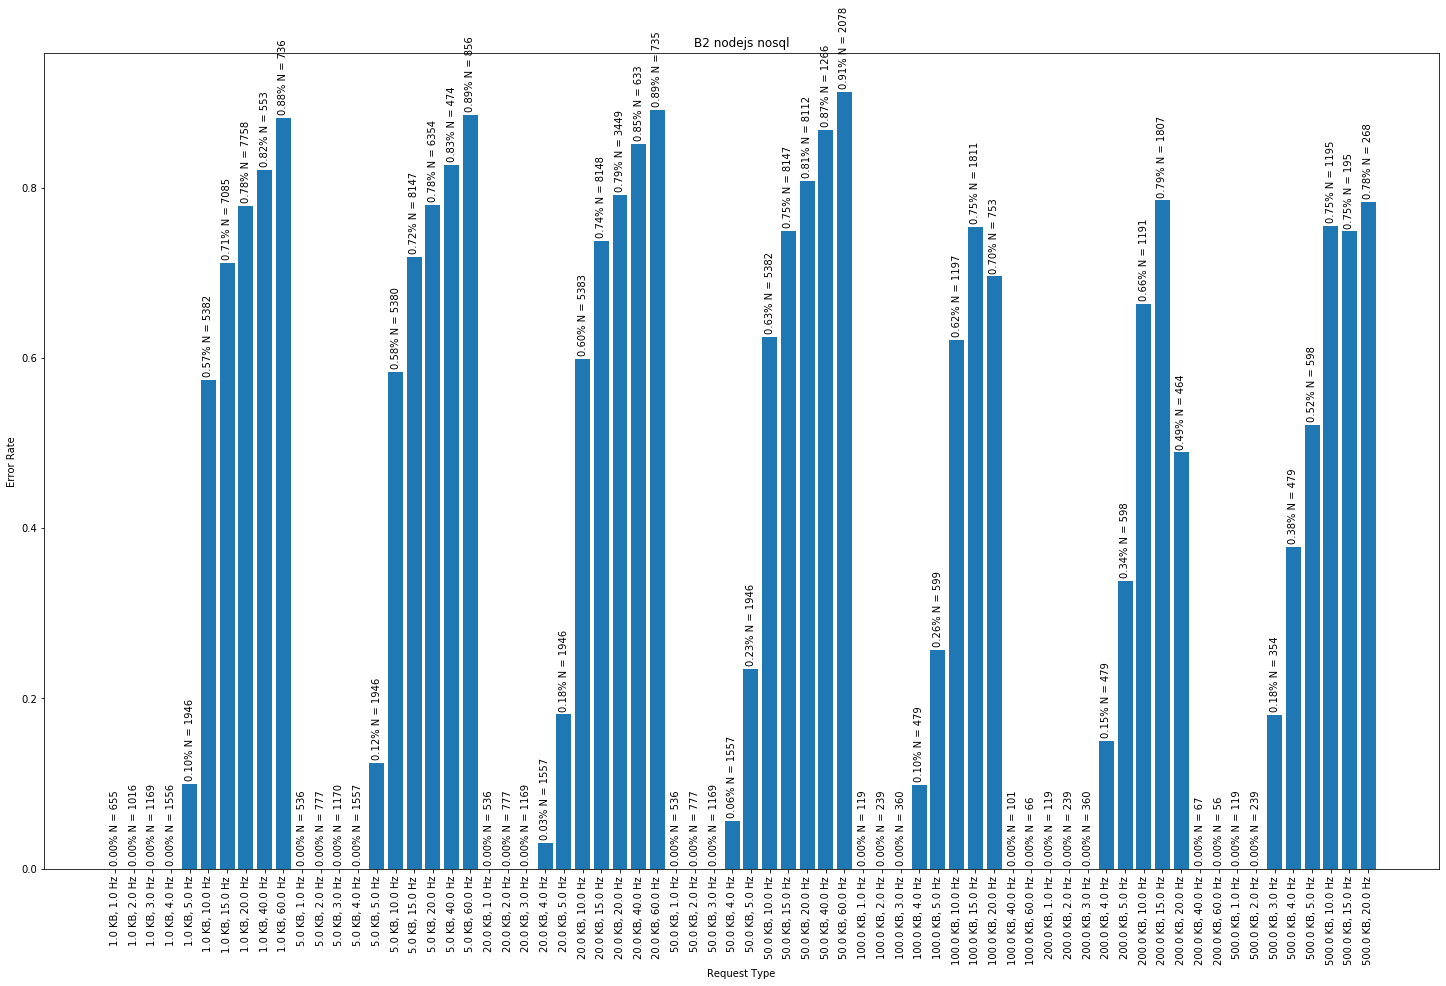

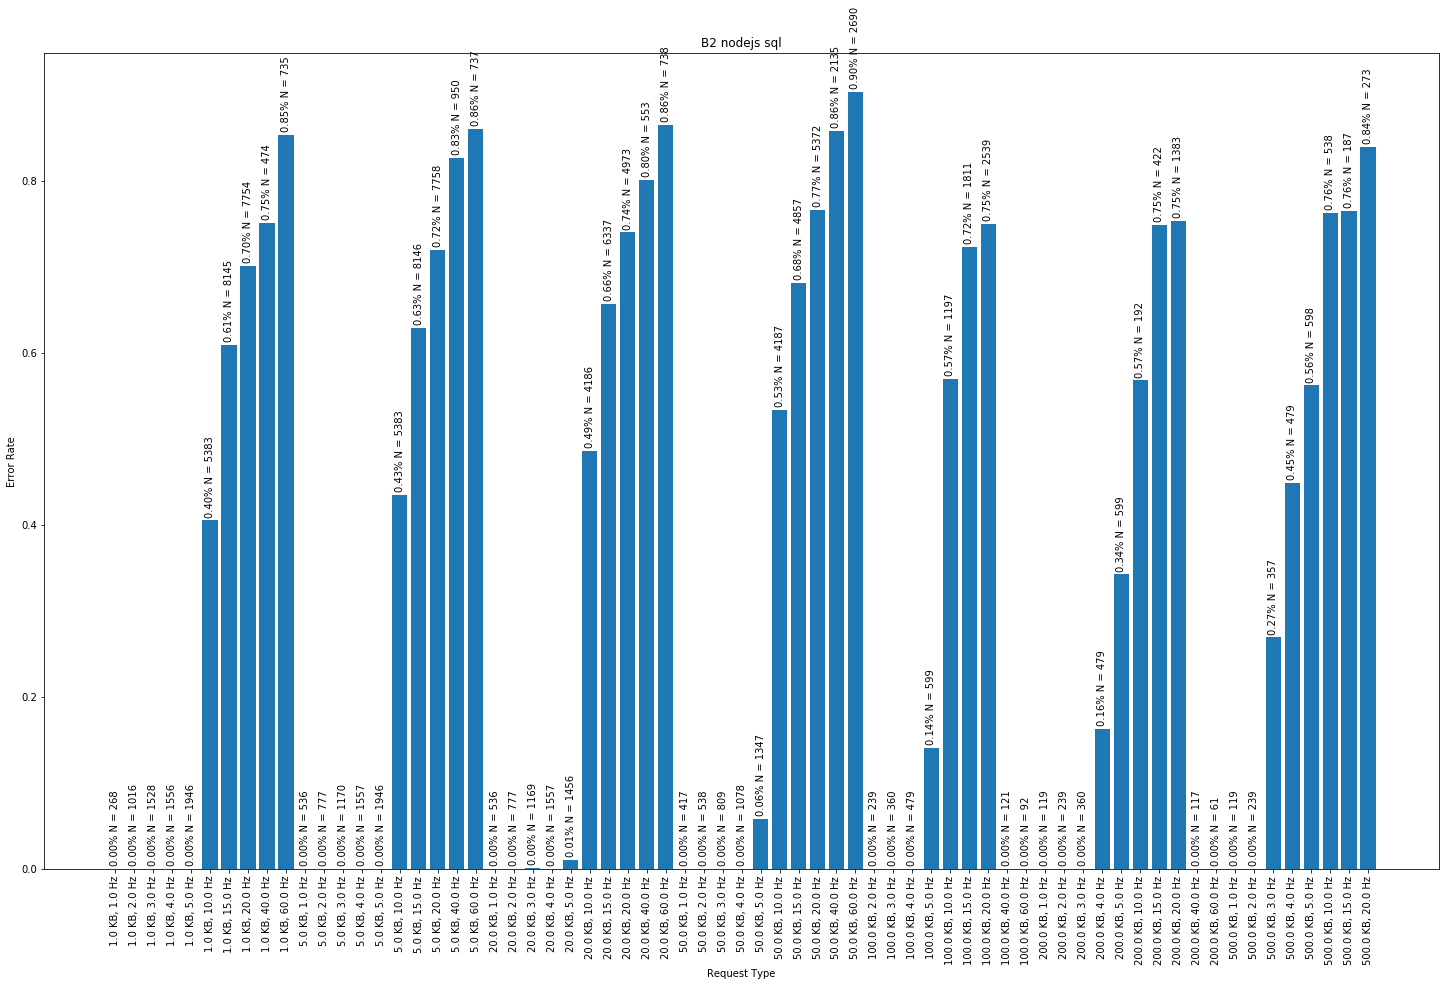

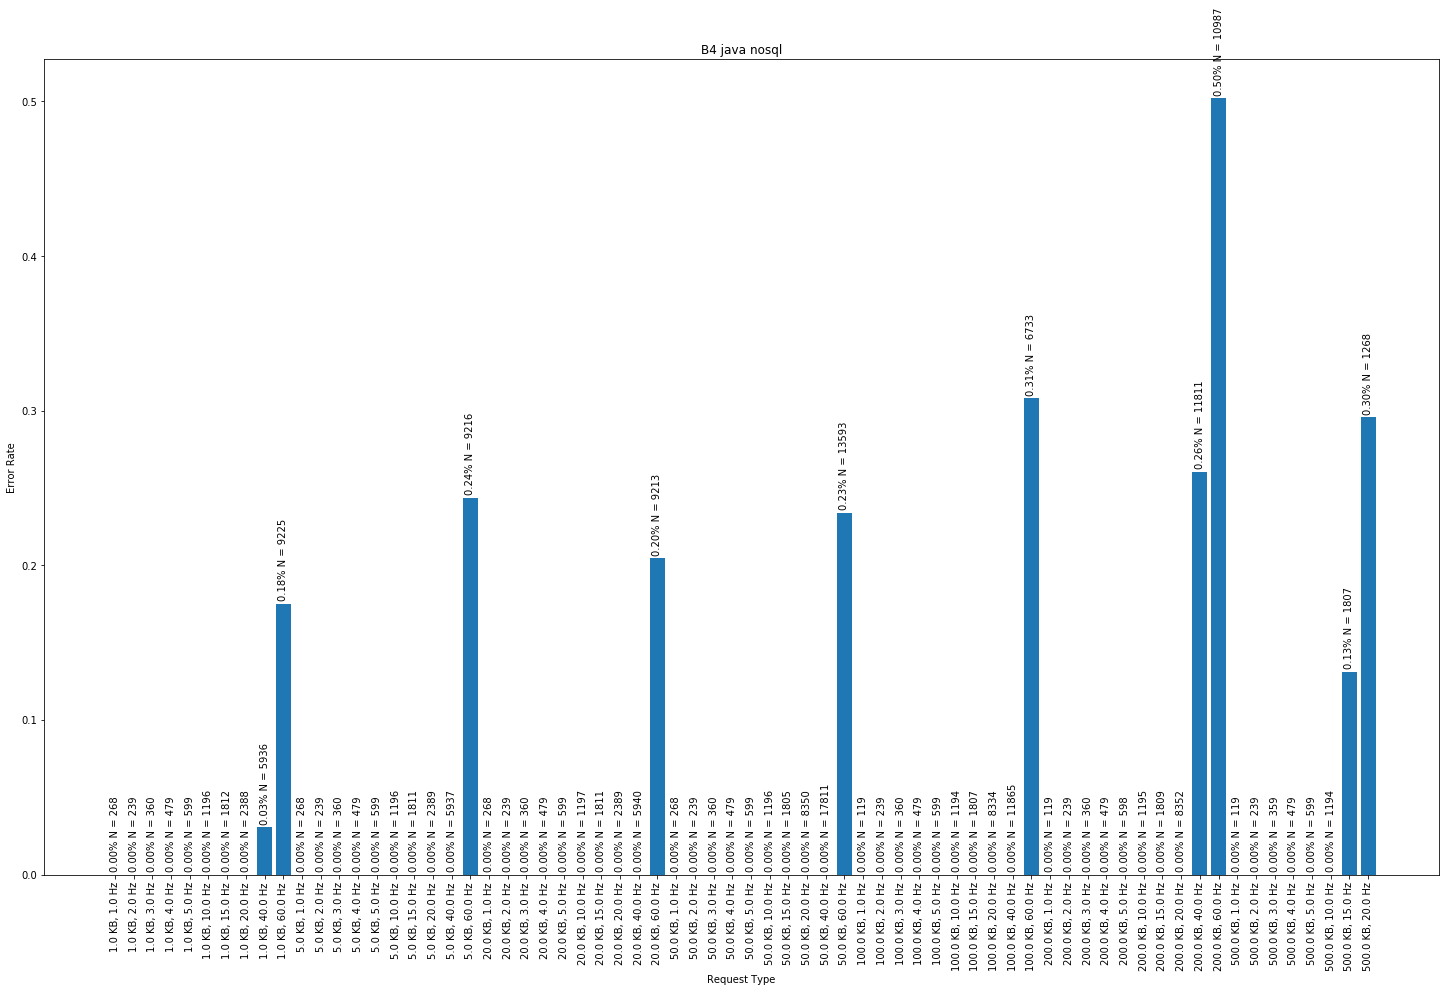

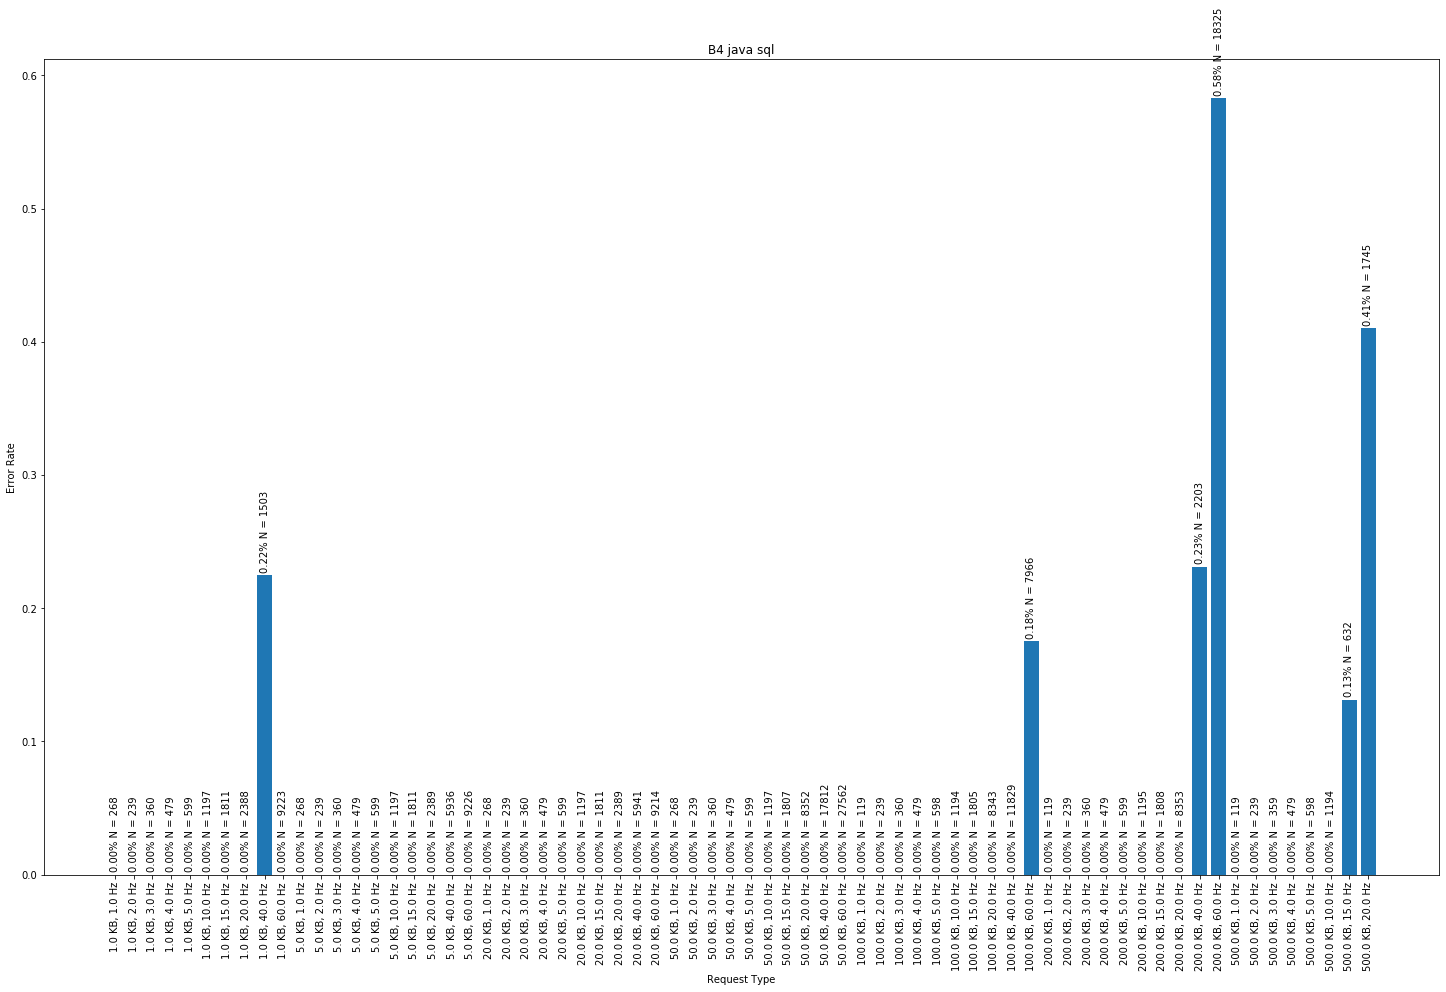

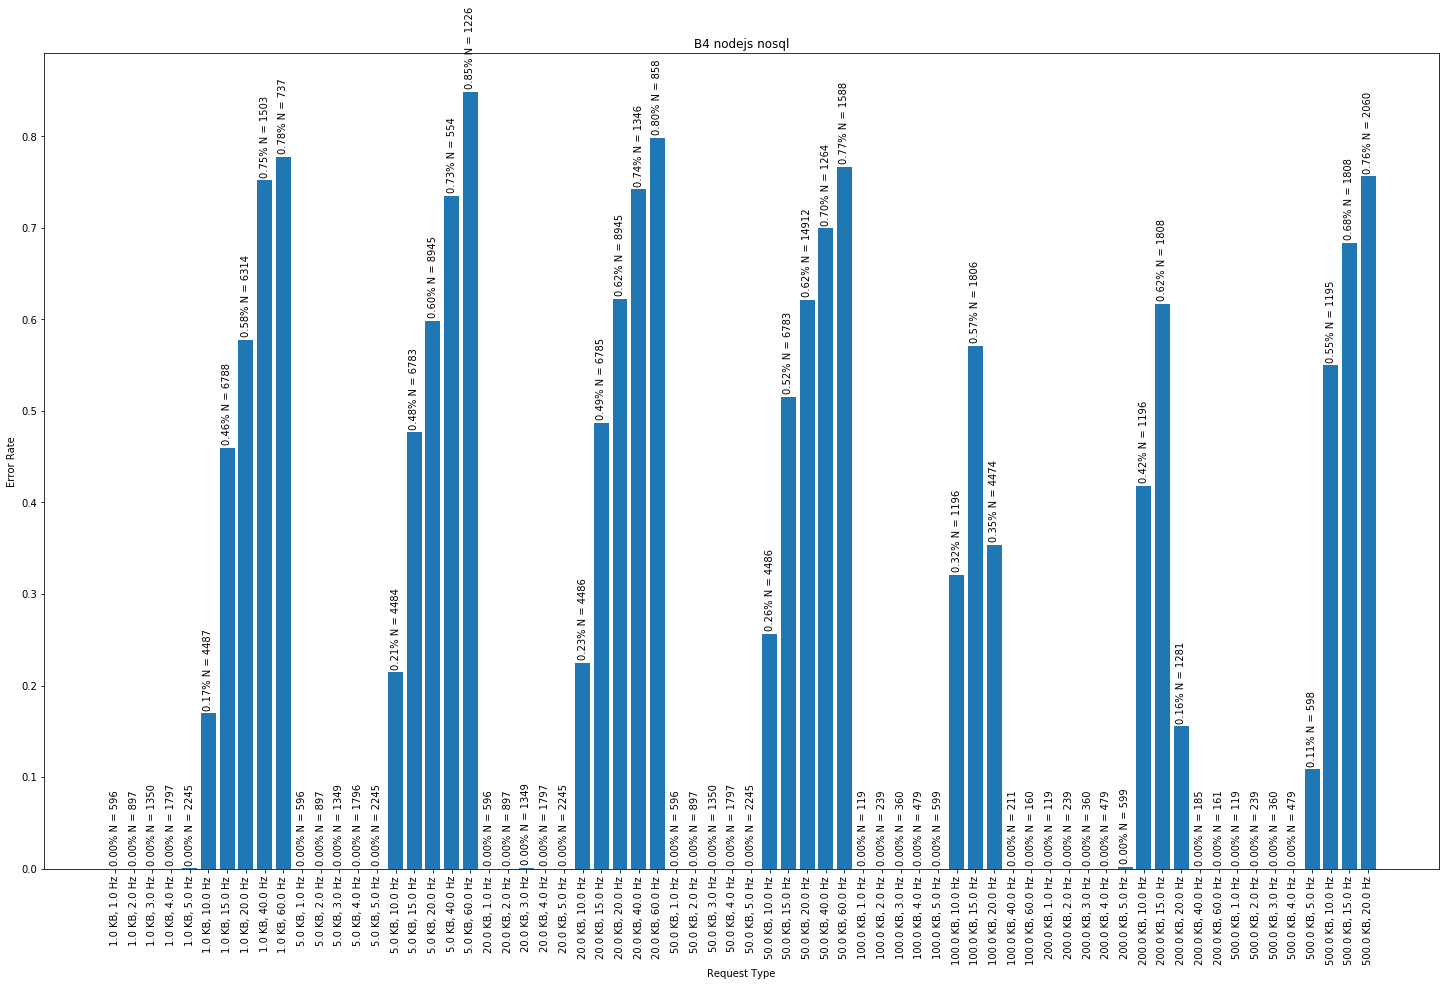

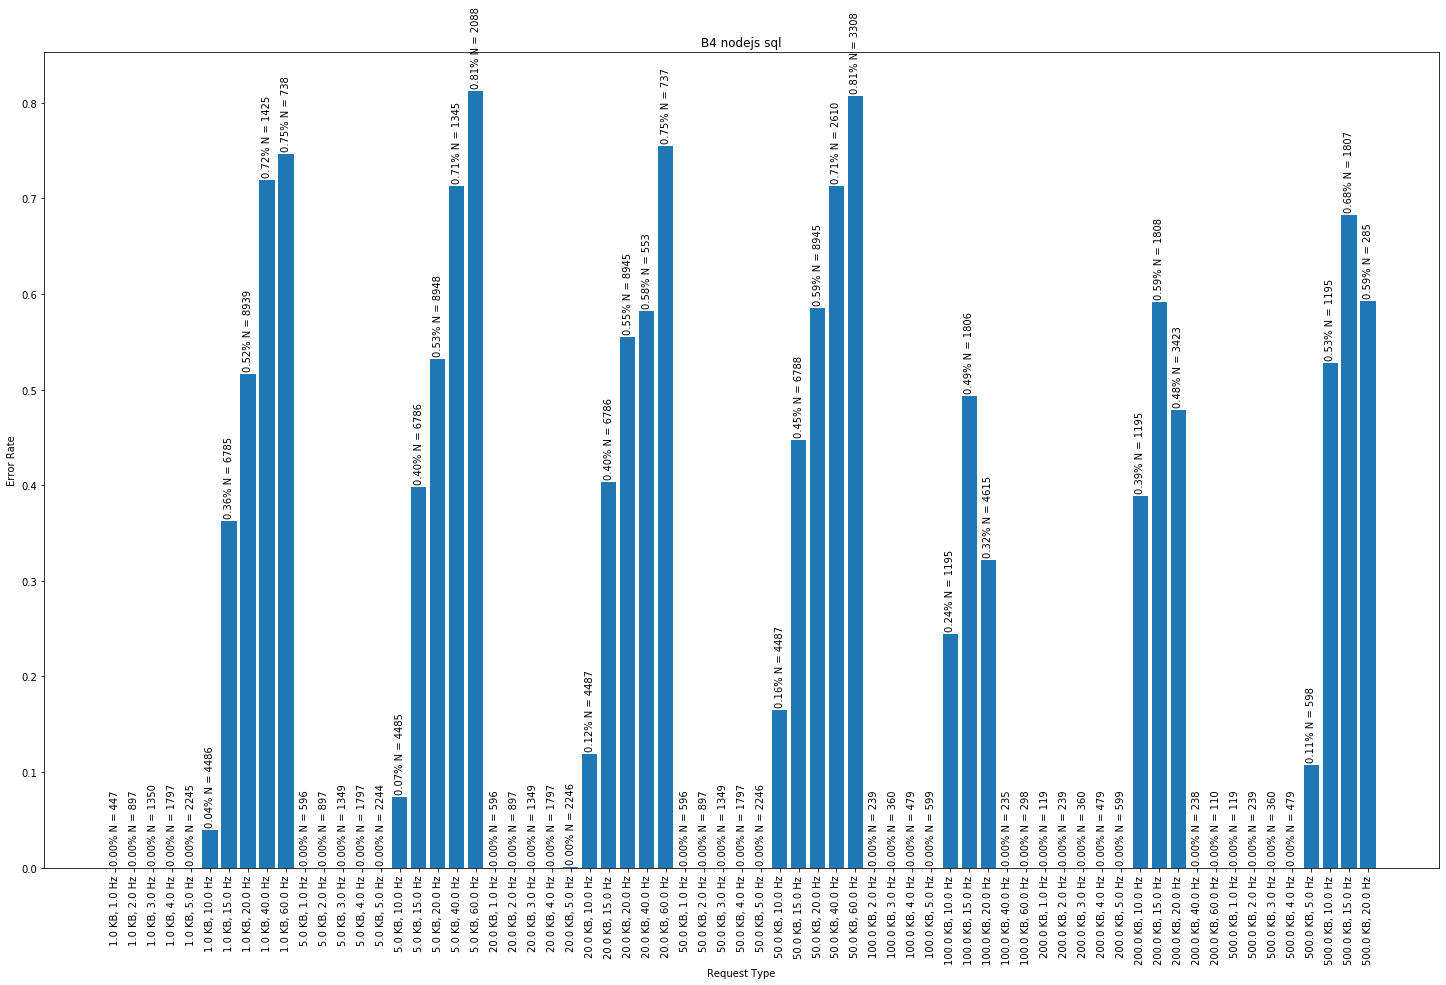

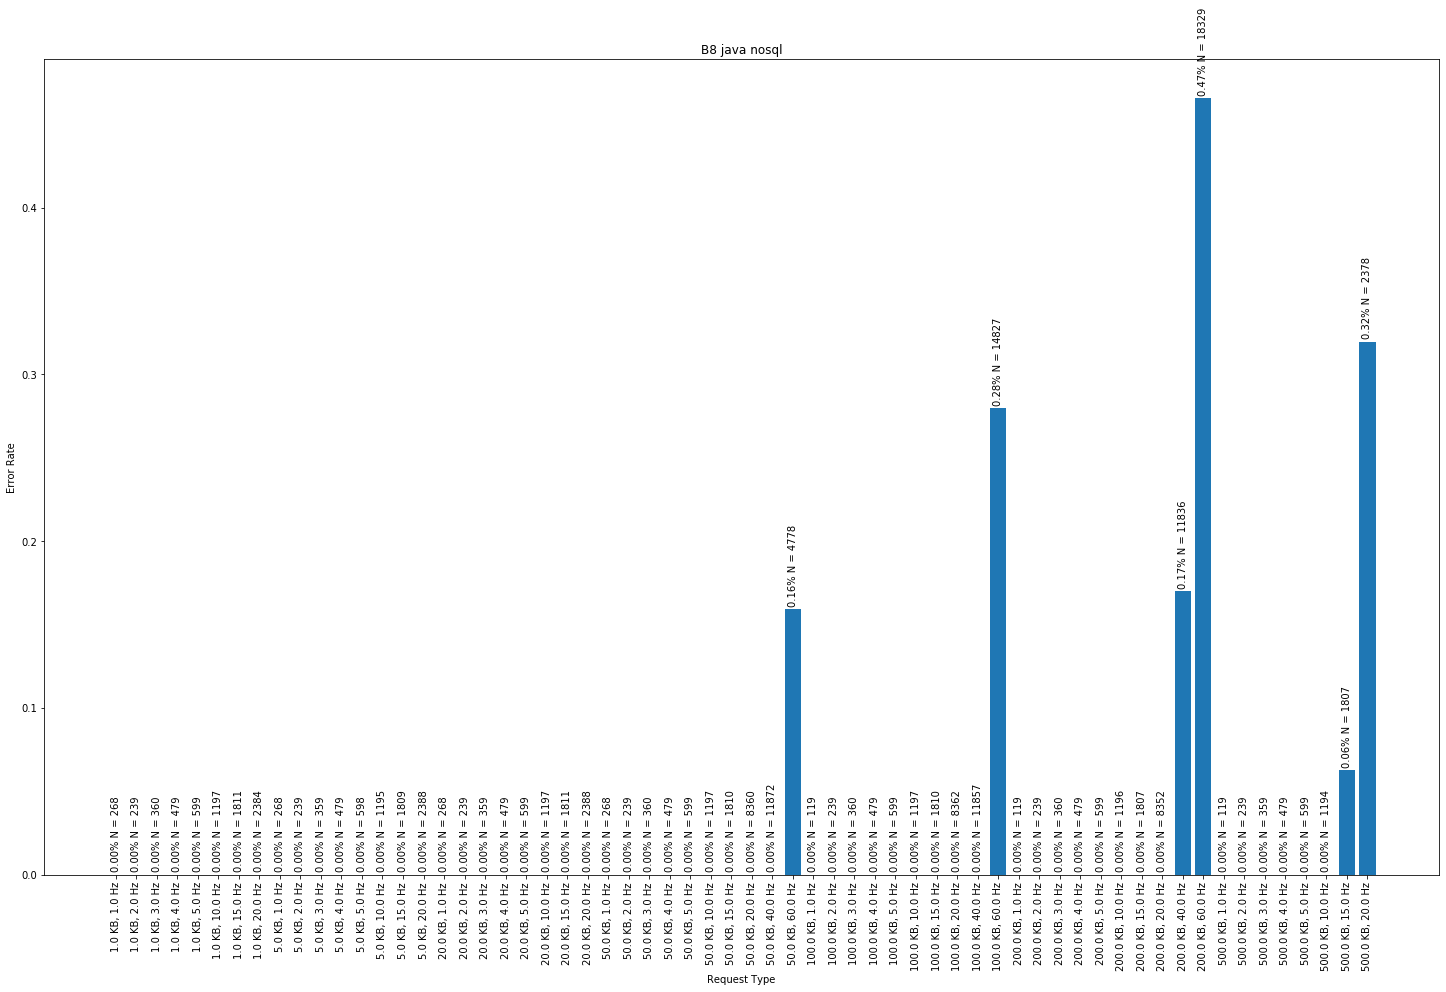

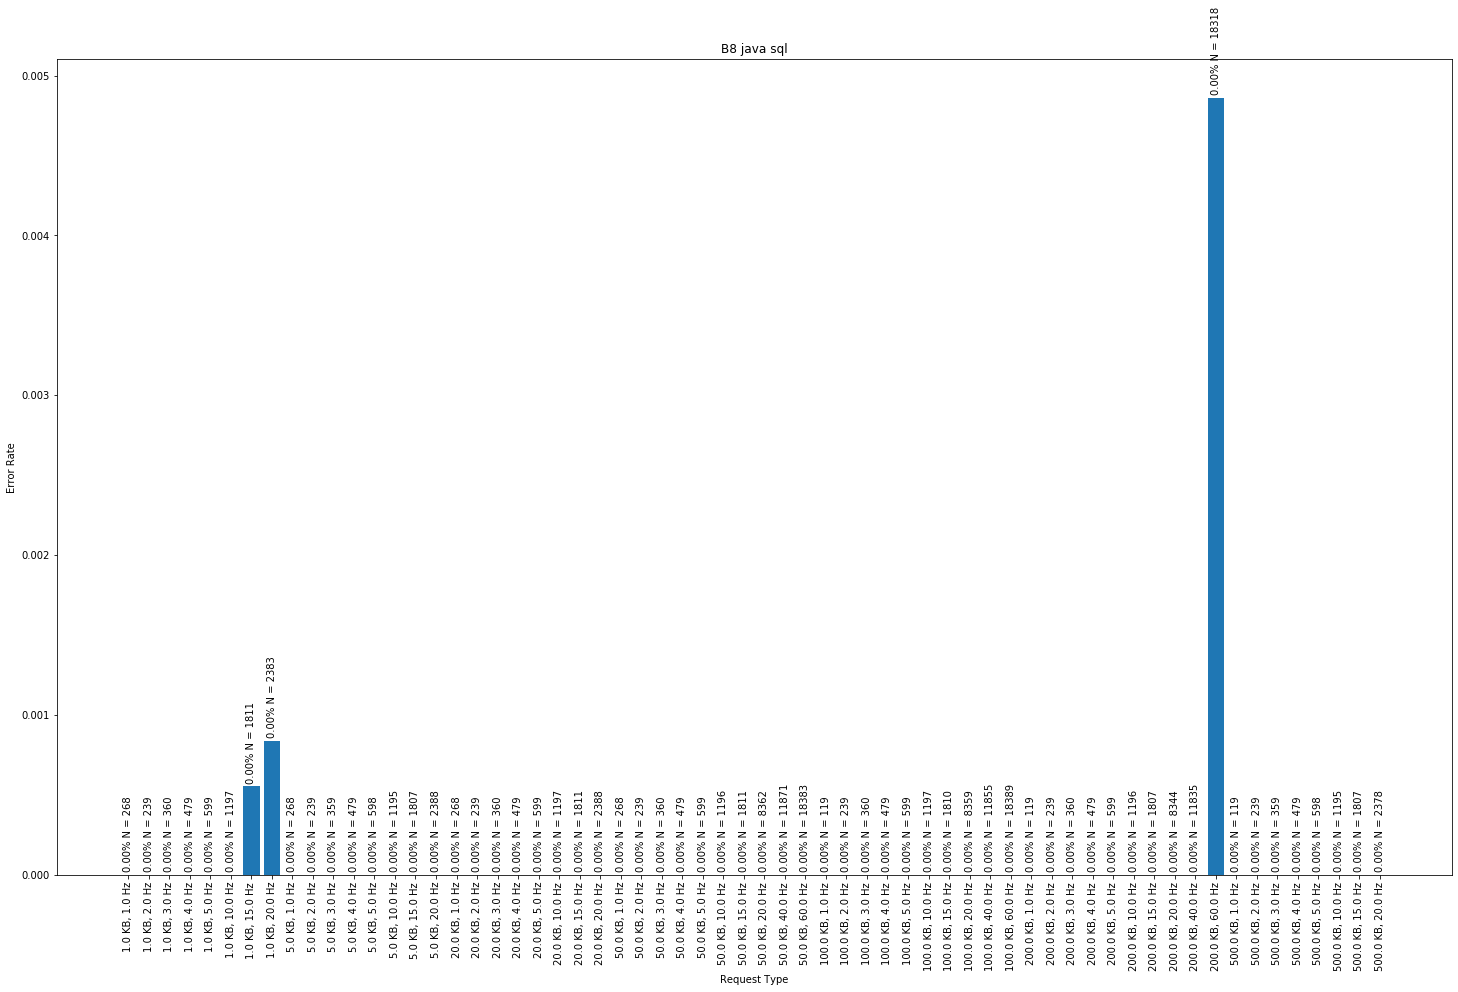

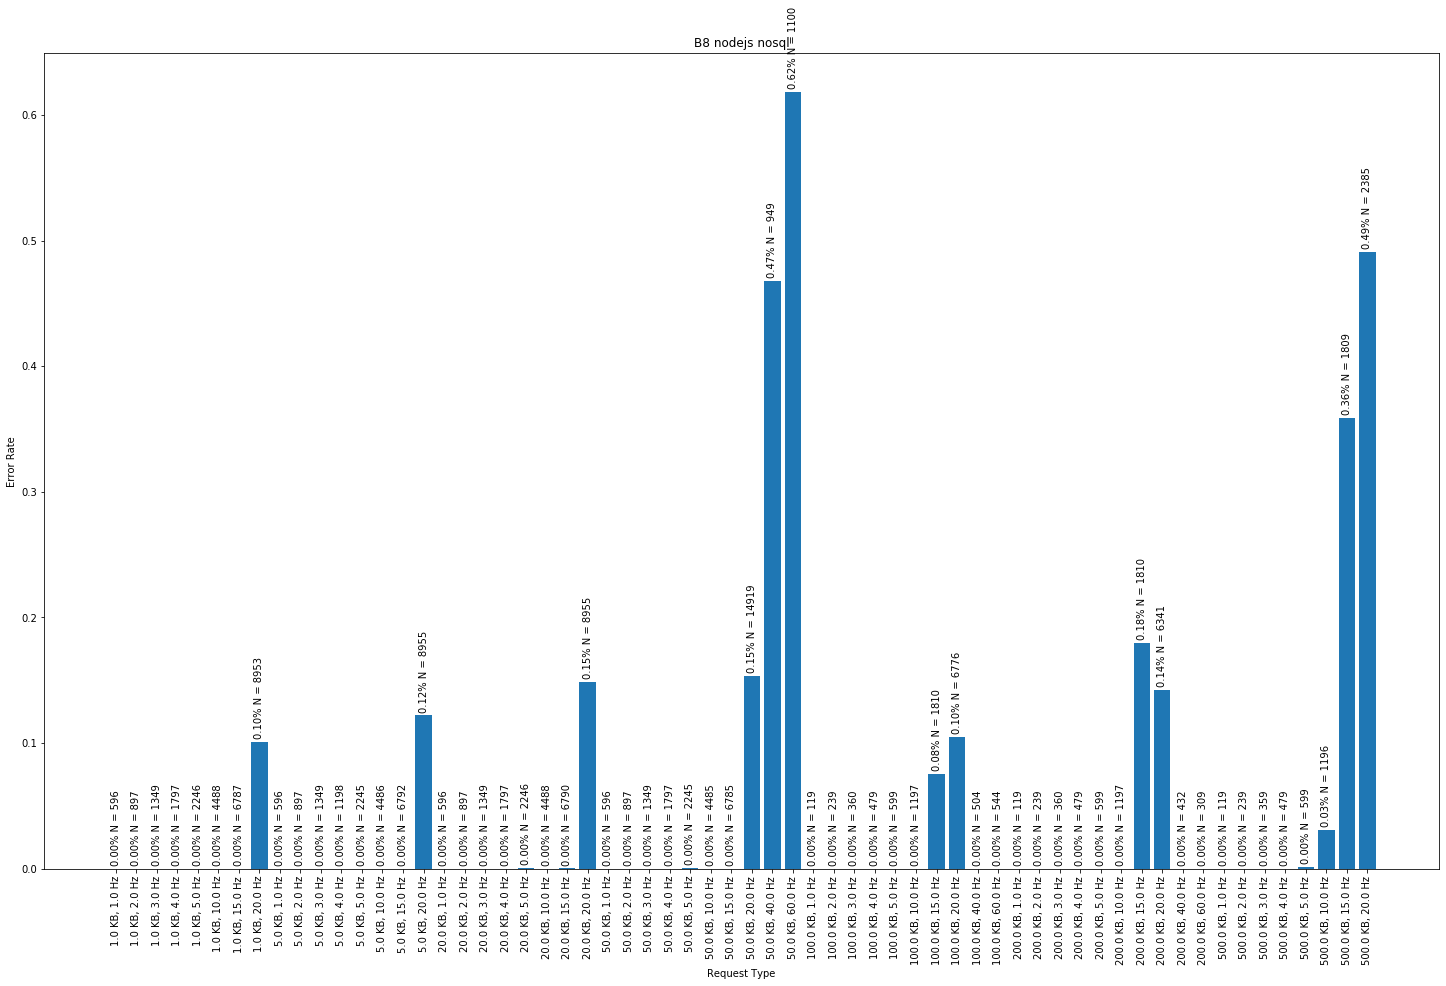

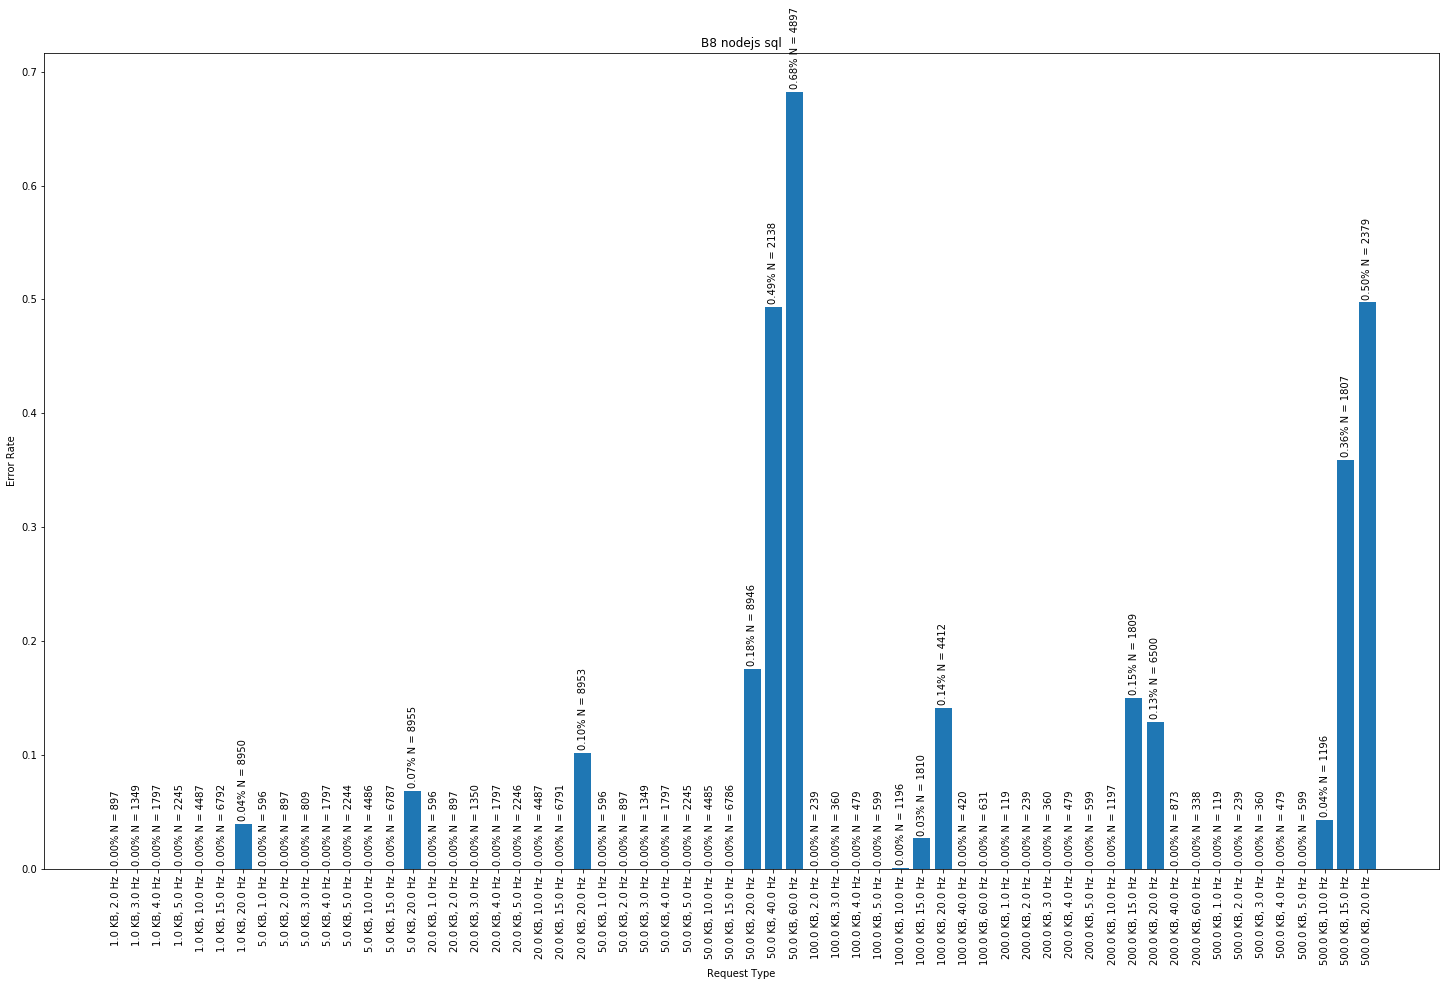

In [5]:
def autolabel2(rects, totals):
    for i, rect in enumerate(rects):
        height = rect.get_height()                
        ax.annotate('{:.2f}% N = {}'.format(height, totals[i]), xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', rotation=90)
        
for comb in combs:
    fig, ax = plt.subplots()
    instance, server, database = comb
    
    partial = df.loc[(df['instanceType'] == instance) & (df['serverType'] == server) & (df['databaseType'] == database)]
    sizes = sorted(partial['requestSize'].unique())
    frequencies = sorted(partial['frequency'].unique())
    
    errors = []
    totals = []
    labels = []

    for size in sizes:
        for frequency in frequencies:
            total = partial.loc[(partial['requestSize'] == size) & (partial['frequency'] == frequency)]
            error = total.loc[(total['clientTotalTime'] <= 0) | (total['timeWrite'] <= 0) | 
                              (total['timeRead'] <= 0) |(total['timeDelete'] <= 0) | (total['totalTime'] <= 0) | 
                              (total['timestamp'] <= 0) | (total['memUsage'] <= 0)]

            if total.shape[0] > 0:
                errors.append(error.shape[0])
                totals.append(total.shape[0])
                labels.append('{} KB, {} Hz'.format(size, frequency))
                
    errors = np.array(errors)
    totals = np.array(totals)
    labels = np.array(labels)
    pct = np.divide(errors, totals)
    
    rects = ax.bar(labels, pct)
    ax.set_xticks(labels)
    ax.set_ylim(0)
    ax.set_title('{} {} {}'.format(instance.upper(), server, database))
    ax.set_xlabel('Request Type')
    ax.set_ylabel('Error Rate')
    ax.xaxis.set_tick_params(rotation=90)
    ax.autoscale_view()
    autolabel2(rects, totals)

    fig.set_size_inches(25, 15)
    plt.savefig('graphs/errors/detailed-{}-{}-{}.png'.format(instance, server, database), bbox_inches='tight')